In [1]:
import pandas as pd
import scipy.stats
import numpy as np
from demand import RandomIIDDemand
from typing import List

### Constants

In [2]:
class AbstractInventoryPolicy() :
    def __init__(self) :
        pass
    def order_quantity(self,t,starting_state_vector) -> List[float] :
        return .0

class ConstantOrderQuantity(AbstractInventoryPolicy) :
    def __init__(self,constant_order_quantity : List[float]) :
        self.constant_order_quantity = constant_order_quantity
    def order_quantity(self,t,starting_state_vector) -> List[float] :
        return self.constant_order_quantity

In [3]:
class RandomIIDDemand :
    def __init__(self, nb_products, distribution: scipy.stats.rv_continuous) :
        self.nb_products = nb_products
        self.distribution = distribution    
    def get_next_demand(self):
        return self.distribution.rvs(size=self.nb_products)

In [4]:
def sell_old_first(extended_state_vector) :
    sales_vector = [np.zeros(life_times[i]) for i in range(nb_products)]
    for i in range(nb_products) : 
        for j in range(life_times[i]) :
            sales_vector[i][j] = np.minimum(extended_state_vector[i][j], np.sum(sales_vector[i]))
    return sales_vector

340.73514006788525

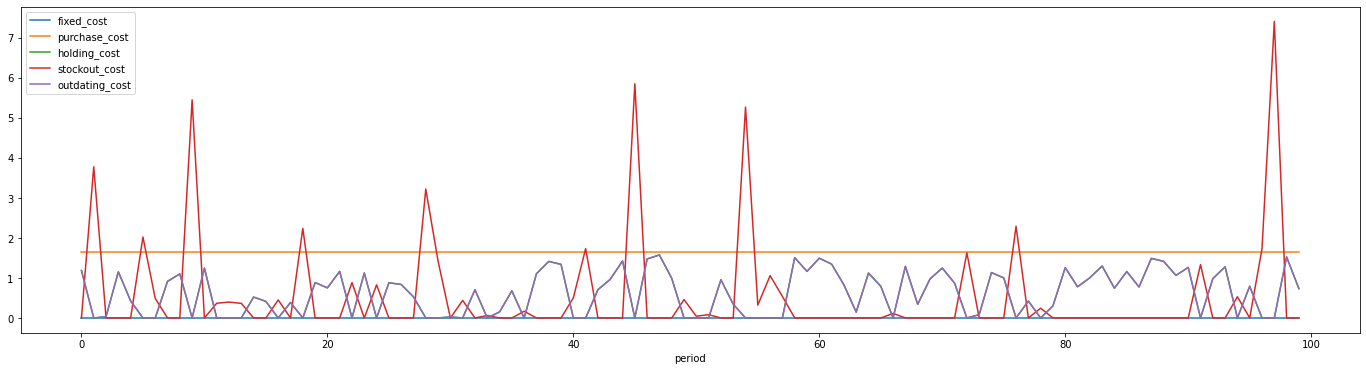

In [19]:
seed = 0
nb_products = 1
nb_periods = 100
unit_volumes = np.ones(nb_products)
life_times = np.ones(nb_products,dtype=int)
lead_times = np.zeros(nb_products,dtype=int)

demand_generator : RandomIIDDemand = RandomIIDDemand(nb_products,scipy.stats.lognorm(s=1))
policy : AbstractInventoryPolicy = ConstantOrderQuantity(demand_generator.distribution.mean()*np.ones(nb_products))

fixed_costs = np.zeros(nb_products)
purchase_costs = np.ones(nb_products)
holding_costs = np.ones(nb_products)
stockout_costs = np.ones(nb_products)
outdating_costs = np.ones(nb_products)

starting_state_vector = [np.zeros(lead_times[i]+life_times[i]-1) for i in range(nb_products)]

history_ = pd.DataFrame(
    .0,
    index = pd.MultiIndex.from_product([np.arange(nb_periods),np.arange(nb_products)],names=["period","product_id"]),
    columns = ["fixed_cost","purchase_cost","holding_cost","stockout_cost","outdating_cost"]
)

for t in range(nb_periods) :
    q = policy.order_quantity(t,starting_state_vector)
    extended_state_vector = [np.append(starting_state_vector[i],q) for i in range(nb_products)]
    demand = demand_generator.get_next_demand()
    sales_vector = sell_old_first(extended_state_vector)

    history_.loc[(t,slice(None)),"fixed_cost"] = np.where(q>0,fixed_costs,0)
    history_.loc[(t,slice(None)),"purchase_cost"] = purchase_costs*q
    history_.loc[(t,slice(None)),"holding_cost"] = holding_costs*np.maximum(0,np.sum([extended_state_vector[i][:life_times[i]]-demand[i] for i in range(nb_products)]))
    history_.loc[(t,slice(None)),"stockout_cost"] = stockout_costs*np.maximum(0,np.sum([demand[i]-extended_state_vector[i][:life_times[i]]  for i in range(nb_products)]))
    history_.loc[(t,slice(None)),"outdating_cost"] = outdating_costs*np.maximum(0,[extended_state_vector[i][0] for i in range(nb_products)]-demand)

    starting_state_vector = [extended_state_vector[i][1:] - sales_vector[i] if (i<life_times[i]) else 0 for i in range(nb_products)]

history_.groupby("period").sum().plot(figsize=(24,6))
history_.sum().sum()